## Reproduce results of Scheme B

Paper: "Statistical supervised meta-ensemble algorithm for data linkage"

Kha Vo, Jitendra Jonnagaddala, Siaw-Teng Liaw

February 2019

Jounal of Biomedical Informatics

In [8]:

import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold

import generator_dataset_epbrn as gd
import plots as pl


np.random.seed(42)


In [19]:

PATH_FILES =  "../data/ePBRN/"
PATH_IMAGES =  "../images/"
PATH_OUTPUT =  "../output/"

trainset = PATH_FILES + 'ePBRN_F_dup.csv' 
testset = PATH_FILES + 'ePBRN_D_dup.csv'

#trainset = PATH_FILES + 'ePBRN_F_rep' 
#testset = PATH_FILES + 'ePBRN_D_rep'


In [10]:

def generate_true_links(df): 
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:    
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]    
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    print("links:", links[0:10])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    unique_match_id = unique_match_id[~np.isnan(unique_match_id)] # remove nan values
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    print("links:", links[0:10])
    return links

def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')  
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')  
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')      
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df, train_true_links):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'svm': # Support Vector Machine
        model = svm.SVC(C = modelparam, kernel = modeltype_2)
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'lg': # Logistic Regression
        if modeltype_2 == "l1":
            model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                    intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                    n_jobs=1, random_state=None, solver='liblinear')
                                    
        if modeltype_2 == "l2":
            model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                    intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                    n_jobs=1, random_state=None)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nb': # Naive Bayes
        model = GaussianNB()
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ), 
                              activation = modeltype_2,random_state=None, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=30000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result

    
def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)

    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)

    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)

    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)

    precision = count_true_pos/(count_true_pos+count_false_pos)
    sensitivity = count_true_pos/(count_true_pos+count_false_neg) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    Fscore = 2*precision*sensitivity/(precision+sensitivity)

    metrics_result = {'no_false':no_false, 'confusion_matrix':confusion_matrix ,'precision':precision,
                     'sensitivity':sensitivity ,'no_links':no_links_found, 'F-score': Fscore, 'true_pos': count_true_pos,
                     'true_neg': count_true_neg, 'false_pos': count_false_pos, 'false_neg': count_false_neg}
                     
    return metrics_result

def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

In [11]:
## TRAIN SET CONSTRUCTION

# Import
print("Import train set...")
df_train = pd.read_csv(trainset, index_col = "rec_id")
train_true_links = generate_true_links(df_train)
print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

# Preprocess train set
df_train['postcode'] = df_train['postcode'].astype(str)

# Final train feature vectors and labels
X_train, y_train = generate_train_X_y(df_train, train_true_links)
print("Finished building X_train, y_train")

Import train set...
links: MultiIndex([( '0',  '0-dup-0'),
            ( '2',  '2-dup-0'),
            ( '3',  '3-dup-0'),
            ( '5',  '5-dup-0'),
            ( '6',  '6-dup-0'),
            ('15', '15-dup-0'),
            ('16', '16-dup-0'),
            ('19', '19-dup-0'),
            ('22', '22-dup-0'),
            ('22', '22-dup-1')],
           )
Train set size: 14078 , number of matched pairs:  3192
links: MultiIndex([(      '7270',        '860'),
            (      '5390',       '5191'),
            (      '5734',       '6265'),
            (       '466',       '4426'),
            (      '5578', '8322-dup-0'),
            (       '769',      '10583'),
            ('6949-dup-0',       '2433'),
            (      '5051',       '6420'),
            ('1184-dup-0',       '4555'),
            (      '6396',      '11096')],
           )
Finished building X_train, y_train


In [12]:
# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import test set...")
df_test = pd.read_csv(testset, index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
     block = rl.Index()
     block.block(on=field)
     candidates = block.index(df_test)
     detects = blocking_performance(candidates, test_true_links, df_test)
     all_candidate_pairs = candidates.union(all_candidate_pairs)
     print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
          detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...
links: MultiIndex([( '3',  '3-dup-0'),
            ( '4',  '4-dup-0'),
            ( '7',  '7-dup-0'),
            ('16', '16-dup-0'),
            ('20', '20-dup-0'),
            ('23', '23-dup-0'),
            ('24', '24-dup-0'),
            ('30', '30-dup-0'),
            ('31', '31-dup-0'),
            ('34', '34-dup-0')],
           )
Test set size: 11731 , number of matched pairs:  2653
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 252552 , detected  1567 /2653 true matched pairs, missed 1086
Number of pairs of matched surname: 33832 , detected  1480 /2653 true matched pairs, missed 1173
Number of pairs of matched postcode: 79940 , detected  2462 /2653 true matched pairs, missed 191
Number of pairs of at least 1 field matched: 362910 , detected  2599 /2653 true matched pairs, missed 54


In [13]:
## TEST SET CONSTRUCTION

# Preprocess test set
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 360311, 1: 2599})
Finished building X_test, y_test


In [14]:
## BASE LEARNERS CLASSIFICATION AND EVALUATION
# Choose model
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
#modeltype = 'svm' # choose between 'svm', 'lg', 'nn'
#modeltype_2 = 'rbf'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn

modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN
models = {'svm': ['linear','rbf'], 'lg': ['l1','l2'], 'nn': ['relu','logistic']}

df_precision = pd.DataFrame()
df_sensitivity = pd.DataFrame()
df_fscore = pd.DataFrame()
df_nb_false = pd.DataFrame()
    
df_precision["param"] = modelparam_range
df_sensitivity["param"] = modelparam_range
df_fscore["param"] = modelparam_range
df_nb_false["param"] = modelparam_range

for i in models:
    for j in models[i]:
        print("Model:",i,", Param_1:",j, ", tuning range:", modelparam_range)
        precision = []
        sensitivity = []
        Fscore = []
        nb_false = []
        count_true_pos = []
        count_true_neg = []
        count_false_pos = []
        count_false_neg = []

        for modelparam in modelparam_range:
            md = train_model(i, modelparam, X_train, y_train, j)
            final_result = classify(md, X_test)
            final_eval = evaluation(y_test, final_result)
            precision += [final_eval['precision']]
            sensitivity += [final_eval['sensitivity']]
            Fscore += [final_eval['F-score']]
            nb_false  += [final_eval['no_false']]
            count_true_pos  += [final_eval['true_pos']]
            count_true_neg  += [final_eval['true_neg']]
            count_false_pos  += [final_eval['false_pos']]
            count_false_neg  += [final_eval['false_neg']]
            
        print("No_false:",nb_false,"\n")
        print("Precision:",precision,"\n")
        print("Sensitivity:",sensitivity,"\n")
        print("F-score:", Fscore,"\n")
        print("")

        df_precision[i + "-" + j] = precision
        df_sensitivity[i + "-" + j] = sensitivity
        df_fscore[i + "-" + j] = Fscore
        df_nb_false[i + "-" + j] = nb_false



BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: linear , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [1217, 1730, 50898, 77644, 77631, 77634, 77636, 78298, 78299, 78492, 81713, 82081, 82189, 84081, 84048, 84110, 84081, 84070, 84126, 84066] 

Precision: [0.6910951327433629, 0.604221635883905, 0.04815985929986716, 0.032190901270431, 0.03218445270219717, 0.03218324874995324, 0.0322291071851584, 0.032104137564436974, 0.032103740697703165, 0.032027328671673634, 0.03081484995848654, 0.030692017005196033, 0.03065292258338444, 0.029983848638670974, 0.02999526815700486, 0.02997382047999631, 0.029983848638670974, 0.029987654178541347, 0.02996829057365235, 0.02998903825073559] 

Sensitivity: [0.9615236629472874, 0.9692189303578299, 0.9903809157368219, 0.9934590227010388, 0.9930742593305117, 0.9930742593305117, 0.9946133128126202, 0.9992304732589458, 0.9992304732589458, 0.9992304732589458, 0.99961

e:\Anaconda\envs\bd4h\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in long_scalars
e:\Anaconda\envs\bd4h\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in long_scalars


No_false: [70202, 73344, 74228, 71806, 72721, 72110, 68327, 73598, 78234, 81628, 72713, 56155, 32222, 6283, 1997, 1560, 1210, 2599, 2599, 2599] 

Precision: [0.03568730339702469, 0.034223035697826004, 0.0338292527366681, 0.03493044822256569, 0.03448138509745605, 0.0347758576840189, 0.03663075968642491, 0.034084495951071624, 0.03214113397087751, 0.03083480759412512, 0.03431190223166844, 0.043940322910279994, 0.0738311034383542, 0.28977402419538917, 0.5678539224526601, 0.6304293246296762, 0.6915862068965517, nan, nan, nan] 

Sensitivity: [0.9996152366294728, 1.0, 1.0, 1.0, 0.9992304732589458, 0.9996152366294728, 0.9996152366294728, 0.9992304732589458, 0.9996152366294728, 0.9992304732589458, 0.993843786071566, 0.9926894959599846, 0.9873028087726049, 0.9769141977683724, 0.9692189303578299, 0.966140823393613, 0.9646017699115044, 0.0, 0.0, 0.0] 

F-score: [0.0689142948088809, 0.06618115148582925, 0.06544456475209628, 0.06750298685782558, 0.06666238850028877, 0.06721341163687164, 0.0706717625

e:\Anaconda\envs\bd4h\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in long_scalars


THEIR RESULTS - BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: rbf , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [510, 926, 1209, 1551, 6462, 78044, 77655, 77638, 77636, 77750, 78320, 79027, 79005, 80086, 80740, 82440, 81889, 82827, 84659, 83496] 

Precision: [0.859552495697074, 0.7517303641287992, 0.6923076923076923, 0.631328320802005, 0.28474311824361975, 0.03205438328805528, 0.03218648716030915, 0.0321933094772016, 0.0322291071851584, 0.03232310660277553, 0.032095408762281404, 0.03182887386062923, 0.03182598039215686, 0.03140987651334648, 0.03117462831635408, 0.030529323909541002, 0.030728439194147864, 0.03038001358027582, 0.029752899646999495, 0.030154839758854208] 

Sensitivity: [0.9607541362062332, 0.9611388995767602, 0.9626779530588688, 0.9692189303578299, 0.9830704116968064, 0.9942285494420932, 0.9934590227010388, 0.9934590227010388, 0.9946133128126202, 0.9992304732589458, 0.9992304732589458, 0.9996152366294728, 0.9992304732589458, 0.9992304732589458, 0.9996152366294728, 0.9988457098884186, 0.9988457098884186, 0.9984609465178915, 0.9988457098884186, 0.9988457098884186] 

F-score: [0.9073401162790699, 0.8436339074636946, 0.8054080154514728, 0.7646076794657762, 0.4415831316972002, 0.06210642695765035, 0.062352841739214425, 0.06236564334194827, 0.06243508924474073, 0.06262056327160494, 0.06219316521780779, 0.06169336167080252, 0.06168719343460135, 0.06090525328330206, 0.0604636008192143, 0.059247763374109905, 0.05962265017627266, 0.05896588159105627, 0.05778455442899912, 0.058542305610680134] 

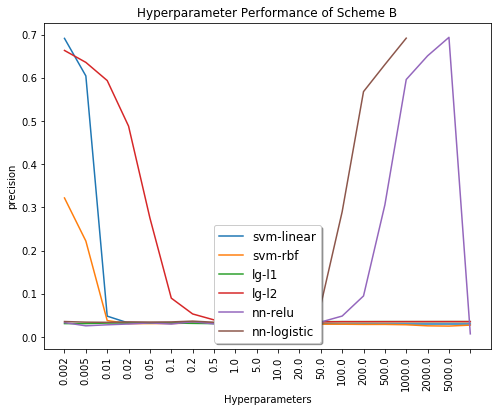

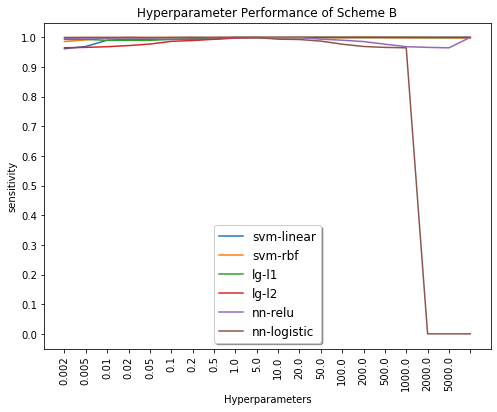

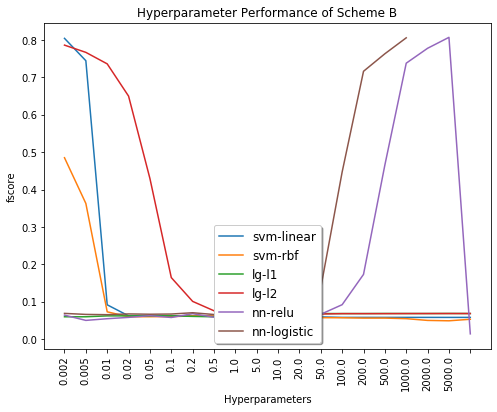

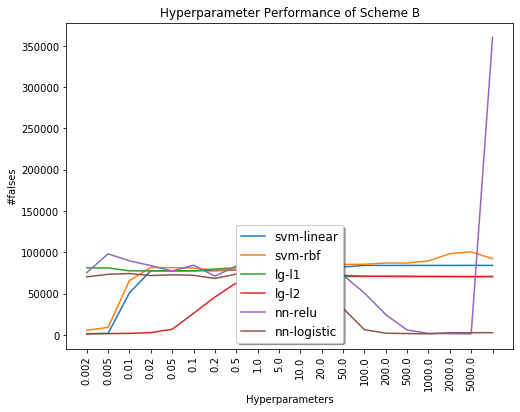

In [15]:
pl.show_plot(df_precision, "Hyperparameter Performance of Scheme B", "precision", "precision_schemeB_1.png")
pl.show_plot(df_sensitivity, "Hyperparameter Performance of Scheme B", "sensitivity", "sensitivity_schemeB_1.png")
pl.show_plot(df_fscore, "Hyperparameter Performance of Scheme B", "fscore", "fscore_schemeB_1.png")
pl.show_plot(df_nb_false, "Hyperparameter Performance of Scheme B", "#falses", "nb_false_schemeB_1.png")


In [16]:
df_precision.to_csv(PATH_OUTPUT + 'schemeB_precision_data.csv')
df_sensitivity.to_csv(PATH_OUTPUT + 'schemeB_sensitivity_data.csv')
df_fscore.to_csv(PATH_OUTPUT + 'schemeB_fscore_data.csv')
df_nb_false.to_csv(PATH_OUTPUT + 'schemeB_nb_false_data.csv')

In [17]:
## ENSEMBLE CLASSIFICATION AND EVALUATION

print("BAGGING PERFORMANCE:\n")
modeltypes = ['svm', 'nn', 'lg'] 
modeltypes_2 = ['rbf', 'relu', 'l2']
modelparams = [0.001, 2000, 0.005]

df_bagging = pd.DataFrame(columns = ['model', 'no_false', 'confusion_matrix', 'precision', 'sensitivity', 
                                            'no_links', 'F-score', 'true_pos', 'true_neg', 'false_pos', 'false_neg'])

nFold = 10
kf = KFold(n_splits=nFold)
model_raw_score = [0]*3
model_binary_score = [0]*3
model_i = 0

for model_i in range(3):
    modeltype = modeltypes[model_i]
    modeltype_2 = modeltypes_2[model_i]
    modelparam = modelparams[model_i]
    print(modeltype, "per fold:")

    iFold = 0
    result_fold = [0]*nFold
    final_eval_fold = [0]*nFold
    for train_index, valid_index in kf.split(X_train):
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        md =  train_model(modeltype, modelparam, X_train_fold, y_train_fold, modeltype_2)
        result_fold[iFold] = classify(md, X_test)
        final_eval_fold[iFold] = evaluation(y_test, result_fold[iFold])
        print("Fold", str(iFold), final_eval_fold[iFold])
        iFold = iFold + 1
    bagging_raw_score = np.average(result_fold, axis=0)
    bagging_binary_score  = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > 0.5] = 1
    bagging_binary_score[bagging_binary_score <= 0.5] = 0
    bagging_eval = evaluation(y_test, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print('')

    model_raw_score[model_i] = bagging_raw_score
    model_binary_score[model_i] = bagging_binary_score

    model = modeltypes[model_i] + " - " + modeltypes_2[model_i] + " - " + str(modelparams[model_i])
    df_bagging.loc[model_i] =  [model] + [v for _, v in bagging_eval.items()]

BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 4530, 'confusion_matrix': [2546, 4477, 53, 355834], 'precision': 0.3625231382600029, 'sensitivity': 0.9796075413620623, 'no_links': 7023, 'F-score': 0.5292039077114945, 'true_pos': 2546, 'true_neg': 355834, 'false_pos': 4477, 'false_neg': 53}
Fold 1 {'no_false': 4244, 'confusion_matrix': [2544, 4189, 55, 356122], 'precision': 0.37784048715282936, 'sensitivity': 0.9788380146210081, 'no_links': 6733, 'F-score': 0.5452207458208316, 'true_pos': 2544, 'true_neg': 356122, 'false_pos': 4189, 'false_neg': 55}
Fold 2 {'no_false': 4412, 'confusion_matrix': [2548, 4361, 51, 355950], 'precision': 0.36879432624113473, 'sensitivity': 0.9803770681031165, 'no_links': 6909, 'F-score': 0.5359697097181322, 'true_pos': 2548, 'true_neg': 355950, 'false_pos': 4361, 'false_neg': 51}
Fold 3 {'no_false': 4502, 'confusion_matrix': [2546, 4449, 53, 355862], 'precision': 0.3639742673338099, 'sensitivity': 0.9796075413620623, 'no_links': 6995, 'F-score': 0.53

In [20]:

thres = .99
print("STACKING PERFORMANCE:\n")
stack_raw_score = np.average(model_raw_score, axis=0)
stack_binary_score = np.copy(stack_raw_score)
stack_binary_score[stack_binary_score > thres] = 1
stack_binary_score[stack_binary_score <= thres] = 0
stacking_eval = evaluation(y_test, stack_binary_score)
print(stacking_eval)

model = "stack bagging"
df_bagging.loc[len(df_bagging)] =  [model] + [v for _, v in stacking_eval.items()]
df_bagging.to_csv(PATH_OUTPUT + 'schemeB_bagging_stack.csv')

STACKING PERFORMANCE:

{'no_false': 1031, 'confusion_matrix': [2505, 937, 94, 359374], 'precision': 0.7277745496804183, 'sensitivity': 0.9638322431704501, 'no_links': 3442, 'F-score': 0.8293328919053137, 'true_pos': 2505, 'true_neg': 359374, 'false_pos': 937, 'false_neg': 94}


THEIR RESULTS - BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 11351, 'confusion_matrix': [2550, 11302, 49, 349009], 'precision': 0.18408894022523822, 'sensitivity': 0.9811465948441709, 'no_links': 13852, 'F-score': 0.31001154944988146}
Fold 1 {'no_false': 388, 'confusion_matrix': [2227, 16, 372, 360295], 'precision': 0.992866696388765, 'sensitivity': 0.8568680261639092, 'no_links': 2243, 'F-score': 0.919867823213548}
Fold 2 {'no_false': 12030, 'confusion_matrix': [2551, 11982, 48, 348329], 'precision': 0.17553154888873598, 'sensitivity': 0.981531358214698, 'no_links': 14533, 'F-score': 0.29780527667522766}
Fold 3 {'no_false': 407, 'confusion_matrix': [2208, 16, 391, 360295], 'precision': 0.9928057553956835, 'sensitivity': 0.8495575221238938, 'no_links': 2224, 'F-score': 0.9156126891975949}
Fold 4 {'no_false': 362, 'confusion_matrix': [2254, 17, 345, 360294], 'precision': 0.992514310876266, 'sensitivity': 0.8672566371681416, 'no_links': 2271, 'F-score': 0.9256673511293635}
Fold 5 {'no_false': 398, 'confusion_matrix': [2217, 16, 382, 360295], 'precision': 0.9928347514554411, 'sensitivity': 0.8530203924586379, 'no_links': 2233, 'F-score': 0.9176324503311257}
Fold 6 {'no_false': 363, 'confusion_matrix': [2253, 17, 346, 360294], 'precision': 0.992511013215859, 'sensitivity': 0.8668718737976144, 'no_links': 2270, 'F-score': 0.9254467036352433}
Fold 7 {'no_false': 11419, 'confusion_matrix': [2550, 11370, 49, 348941], 'precision': 0.18318965517241378, 'sensitivity': 0.9811465948441709, 'no_links': 13920, 'F-score': 0.30873539560506086}
Fold 8 {'no_false': 10576, 'confusion_matrix': [2550, 10527, 49, 349784], 'precision': 0.19499885294792382, 'sensitivity': 0.9811465948441709, 'no_links': 13077, 'F-score': 0.3253380964531768}
Fold 9 {'no_false': 10434, 'confusion_matrix': [2549, 10384, 50, 349927], 'precision': 0.19709270857496328, 'sensitivity': 0.9807618314736437, 'no_links': 12933, 'F-score': 0.3282255987638424}
svm bagging: {'no_false': 362, 'confusion_matrix': [2254, 17, 345, 360294], 'precision': 0.992514310876266, 'sensitivity': 0.8672566371681416, 'no_links': 2271, 'F-score': 0.9256673511293635}

nn per fold:
Fold 0 {'no_false': 1218, 'confusion_matrix': [2506, 1125, 93, 359186], 'precision': 0.6901679977967502, 'sensitivity': 0.9642170065409773, 'no_links': 3631, 'F-score': 0.8044943820224719}
Fold 1 {'no_false': 1045, 'confusion_matrix': [2506, 952, 93, 359359], 'precision': 0.7246963562753036, 'sensitivity': 0.9642170065409773, 'no_links': 3458, 'F-score': 0.8274723460458973}
Fold 2 {'no_false': 1249, 'confusion_matrix': [2507, 1157, 92, 359154], 'precision': 0.6842248908296943, 'sensitivity': 0.9646017699115044, 'no_links': 3664, 'F-score': 0.8005748044068337}
Fold 3 {'no_false': 1039, 'confusion_matrix': [2506, 946, 93, 359365], 'precision': 0.7259559675550405, 'sensitivity': 0.9642170065409773, 'no_links': 3452, 'F-score': 0.8282928441579904}
Fold 4 {'no_false': 1111, 'confusion_matrix': [2506, 1018, 93, 359293], 'precision': 0.7111237230419978, 'sensitivity': 0.9642170065409773, 'no_links': 3524, 'F-score': 0.8185529968969458}
Fold 5 {'no_false': 1024, 'confusion_matrix': [2506, 931, 93, 359380], 'precision': 0.7291242362525459, 'sensitivity': 0.9642170065409773, 'no_links': 3437, 'F-score': 0.8303512259774685}
Fold 6 {'no_false': 1118, 'confusion_matrix': [2506, 1025, 93, 359286], 'precision': 0.7097139620504106, 'sensitivity': 0.9642170065409773, 'no_links': 3531, 'F-score': 0.8176182707993473}
Fold 7 {'no_false': 1289, 'confusion_matrix': [2509, 1199, 90, 359112], 'precision': 0.6766450916936354, 'sensitivity': 0.9653712966525587, 'no_links': 3708, 'F-score': 0.795623909941335}
Fold 8 {'no_false': 1160, 'confusion_matrix': [2506, 1067, 93, 359244], 'precision': 0.7013713965855024, 'sensitivity': 0.9642170065409773, 'no_links': 3573, 'F-score': 0.8120544394037589}
...

STACKING PERFORMANCE:

{'no_false': 407, 'confusion_matrix': [2208, 16, 391, 360295], 'precision': 0.9928057553956835, 'sensitivity': 0.8495575221238938, 'no_links': 2224, 'F-score': 0.9156126891975949}